#Feature Engineering - 신용거래 이상탐지 데이터 다루기 (프로젝트)
###**분석자:** 박의진
###**데이터 파일**: fraud.csv
---

##**프로젝트 개요**
#### 본 프로젝트는 fraud.csv 데이터를 정제하고 Feature Engineering(FE)를 수행하여 사기 거래를 탐지(Fraud Detection)하는 예측 모델을 만들기 위한 목표를 갖는다.<br> 이를 통해 금융기관의 금전적 손실을 줄이고, 고객 불편을 최소화하며, 신용카드 거래의 신뢰성을 높이기 위한 목적을 가지고 있다.

###**데이터셋 포함 정보**
- trans_date_trans_time (거래정보) : 거래 발생 일시
- cc_num (고객정보) : 신용카드번호
- merchant (거래정보) : 가맹점 이름
- category (거래정보) : 가맹점 업종
- amt (거래정보) : 거래금액
- first (고객 정보): 고객 이름
- last (고객 정보) : 고객 성
- gender (고객 정보) : 고객 성별
- street (고객 정보) : 도로명
- city (고객 정보) : 도시명
- state (고객 정보) : 주명
- zip (고객 정보) : 우편번호
- lat (고객 위치정보) : 거주지 위도
- long (고객 위치정보) : 거주지 경도
- city_pop (고객 정보) : 거주도시 인구수
- job (고객 정보) : 고객 직업
- dob (고객 정보) : 고객 생년월일
- trans_num (거래 정보) : 거래 고유 ID
- unix_time (거래 정보) : 거래 일시
- merch_lat (거래 위치정보) : 가맹점 위도
- merch_long (거래 위치정보) : 가맹점 경도
- **is_fraud : 정상거래 vs. 비정상거래 (타겟변수)** -> Binary Classification(이진분류)

###**일반적 도메인 상식 (가설) **
사기 거래는 보통:  

	- 큰 금액으로 한 번 치고 빠지거나,
	- 아주 작은 금액 여러 번 테스트하거나,
	- 정상 대비 패턴이 다르게 움직임




#🧭 1단계. 분석 플로우 및 처리 방향 수립

	1.	데이터 구조 파악 및 전처리 방향 수립
	•	고객 정보 / 거래 정보 / 위치 정보 (독립변수) vs. 타겟 변수 (종속변수)
	•	중복되는 값 제거 (예. 고객주소랑 좌표)  
	•	불필요한 식별자 컬럼 제거 (이름, 거래고유번호)
	•	컬럼명 명확하게 rename (고객과 가맹점 위치정보 구분)
	2.	결측치 및 이상치 처리
	•	결측치 여부 확인 → 적절한 처리
	•	IQR 기반 이상치 탐지 → 논리에 따라 삭제 또는 활용 판단 (예. flag / log)
	3.	탐색적 데이터 분석(EDA)
	•	정상 거래 vs 사기 거래 패턴 비교
	•	금액/시간/업종/위치 기반 분포 분석
	•	FE 아이디어 도출을 위한 패턴 파악
	4.	핵심 Feature Engineering(필수 평가 요소) - 최소 2개 이상 파생변수 생성
	•	시간 기반: 새벽/야간 거래 여부, 주중·주말 차이, 갑작스러운 거래 간격(time_diff)
	•	금액 기반: 분포 왜곡이 크므로 log 변환, 비정상적으로 큰 거래, 매우 작은 금액 반복 결제 등 이상치 패턴을 flag로 표시
	•	위치 기반: 고객 생활권(lat/long)과 가맹점 위치(merch_lat/merch_long) 간 거리 계산 (평소 거래지역과 다른 위치라면 사기 가능성이 높지 않을까?)
	5.	불균형 데이터 처리 전략 수립
	•	is_fraud는 정상 비율이 압도적 → 우리가 알고 싶은건 사기를 얼마나 잡았는지임 (Recall)
	•	불균형 처리는 class_weight='balanced' / SMOTE(오버샘플링 또는 언더샘플링) / threshold(판단기준값) 조정
	•	평가지표는 Accuracy보다는 Recall·F1·AUPRC 중심
	6.	Baseline 모델 구축 및 성능 평가
	•	Logistic Regression 또는 RandomForest로 초기 성능 확인
	•	모델 해석 및 주요 변수 분석 -> 사기를 얼마나 놓치지 않았는지?(Recall) 정상거래를 과도하게 사기로 찍었는지(Precision), 두 지표의 균형(F1)을 중심으로 모델 판단
	7.	모델 개선 방향 수립(선택)
	•	더 정교한 FE 추가 가능성 검토
	•	강화된 모델(XGBoost, LightGBM 등) 적용 : 복잡한 비선형 패턴, 대용량, 불균형 데이터에 강한 알고리즘 중심
	•	임계값(Threshold) 조정하여 False Negative(사기 놓침) 최소화 & False Positive(정상 거래 오탐) 균형 조절





#2단계. 데이터 로드 & 기본 구조 파악

In [202]:
from google.colab import drive

In [203]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [204]:
#데이터 분석 기본 세팅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium.plugins import MarkerCluster   # 클러스터까지 쓸 거면 같이

In [205]:
#데이터 불러오기
df_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fraud.csv')
df = df_raw.copy()

In [206]:
pd.set_option('display.max_columns', 50)

In [207]:
df.head()


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,NJ,7208,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,NJ,7060,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,MI,48174,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,LA,70808,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0


In [208]:
df.tail()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
491129,2020-12-31 23:56:48,6011109736646996,fraud_Botsford and Sons,home,134.26,Rebecca,Erickson,F,594 Berry Lights Apt. 392,Wilmington,NC,28405,34.2651,-77.8670,186140,English as a second language teacher,1983-02-08,fc860b0d1f89b0b068c9c8db27b6bcc5,1388534208,34.853497,-78.664158,0
491130,2020-12-31 23:56:57,213112402583773,"fraud_Baumbach, Hodkiewicz and Walsh",shopping_pos,25.49,Ana,Howell,F,4664 Sanchez Common Suite 930,Bradley,SC,29819,34.0326,-82.2027,1523,Research scientist (physical sciences),1984-06-03,0f0c38fe781b317f733b845c0d6ba448,1388534217,35.008839,-81.475156,0
491131,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,Lake Jackson,TX,77566,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
491132,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,Burbank,WA,99323,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
491133,2020-12-31 23:59:34,4170689372027579,fraud_Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,Edmond,OK,73034,35.6665,-97.4798,116001,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.210097,-97.036372,0


In [209]:
df.info()

#491134개 데이타 : 결측 없는 것으로 나옴

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

In [210]:
# 결측치 없는지 재점검
df.isnull().sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [211]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,4.911340e+05,491134.000000,491134.000000,491134.000000,491134.000000,4.911340e+05,4.911340e+05,491134.000000,491134.000000,491134.000000
mean,3.706013e+17,69.050120,50770.532384,37.931230,-90.495619,1.213922e+05,1.358730e+09,37.930272,-90.495411,0.002533
std,1.260229e+18,160.322867,26854.947965,5.341193,12.990732,3.725751e+05,1.819402e+07,5.372986,13.004100,0.050264
min,5.038744e+11,1.000000,1843.000000,24.655700,-122.345600,4.600000e+01,1.325376e+09,23.655789,-123.345106,0.000000
25%,2.131124e+14,8.960000,28405.000000,33.746700,-97.235100,1.228000e+03,1.343087e+09,33.781388,-96.984814,0.000000
50%,3.531130e+15,42.170000,49628.000000,38.507200,-87.591700,5.760000e+03,1.357257e+09,38.545124,-87.573441,0.000000
75%,4.653879e+15,80.330000,75048.000000,41.520500,-80.731000,5.083500e+04,1.374626e+09,41.624294,-80.685567,0.000000
max,4.956829e+18,25086.940000,99323.000000,48.887800,-69.965600,2.906700e+06,1.388534e+09,49.887523,-68.965624,1.000000


In [212]:
#타겟변수 고유값 비율 확인 - 엄청난 불균형이다!
df['is_fraud'].value_counts(normalize=True)

,proportion
is_fraud,
0,0.997467
1,0.002533


In [213]:
#문자열 결측치 추가 탐지
(df == '').sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [214]:
#스페이스 결측 추가 탐지
(df == ' ').sum()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [215]:
#문자열 결측구분 케이스 추가 탐지
df.isin(['NULL', 'NaN', 'NA', 'N/A', 'unknown', 'Unknown', '?']).sum()


,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


In [216]:
#결측값이 존재하는 행 직접 확인  : 실제 없음
df[df.isnull().any(axis=1)]

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud


In [217]:
#중복값 확인
df.duplicated().sum()


np.int64(0)

In [218]:
df[df.duplicated()]

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud


#### 2-1. 컬럼명 정리 및 개인정보 비식별화

- 고객 이름, 상세 주소 등 직접 식별 가능한 컬럼 처리 (이름, 생년월일, 상세주소 제거)
- 거래고유ID는 예측에 큰 영향을 줄 정보가 아니므로 삭제
- `trans_date_trans_time`와 `unix_time`은 동일한 시간 정보를 가지므로,
  시간 파생변수 생성에는 `unix_time`을 주로 활용하고 문자열 컬럼은 제거
- 위치 정보는 다음과 같이 구분
  - `lat`, `long` → 고객(생활권) 위치
  - `merch_lat`, `merch_long` → 가맹점(거래 발생 장소) 위치
- 이후 혼동을 줄이기 위해 컬럼명을 직관적으로 변경
  - 예: `lat` → `cust_lat`, `long` → `cust_long`

In [219]:
# 1) 불필요 컬럼 삭제 (cc_num는 모델이 학습할 정보는 아니지만 FE 그룹키로 사용할 수 있으므로 일단 남기기 )
drop_cols = ['first', 'last', 'street', 'city', 'state', 'zip','dob', 'trans_num', 'trans_date_trans_time', 'job']

df = df.drop(columns=drop_cols)

# 2) 컬럼명 명확히 변경
df = df.rename(columns={
    'lat': 'cust_lat',
    'long': 'cust_long',
    'merch_lat': 'store_lat',
    'merch_long': 'store_long'
})

In [220]:
df.head()

,cc_num,merchant,category,amt,gender,cust_lat,cust_long,city_pop,unix_time,store_lat,store_long,is_fraud
0,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0
1,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,M,40.6747,-74.2239,124967,1325376754,40.079588,-74.848087,0
2,180048185037117,fraud_Kling-Grant,grocery_net,46.28,F,40.6152,-74.4150,71485,1325377036,40.021888,-74.228188,0
3,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,M,42.2203,-83.3583,31515,1325377215,42.360426,-83.552316,0
4,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,F,30.4066,-91.1468,378909,1325377421,29.737426,-90.853194,0


In [221]:
df.shape

(491134, 12)

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   cc_num      491134 non-null  int64  
 1   merchant    491134 non-null  object 
 2   category    491134 non-null  object 
 3   amt         491134 non-null  float64
 4   gender      491134 non-null  object 
 5   cust_lat    491134 non-null  float64
 6   cust_long   491134 non-null  float64
 7   city_pop    491134 non-null  int64  
 8   unix_time   491134 non-null  int64  
 9   store_lat   491134 non-null  float64
 10  store_long  491134 non-null  float64
 11  is_fraud    491134 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 45.0+ MB


In [223]:
df.describe()

,cc_num,amt,cust_lat,cust_long,city_pop,unix_time,store_lat,store_long,is_fraud
count,4.911340e+05,491134.000000,491134.000000,491134.000000,4.911340e+05,4.911340e+05,491134.000000,491134.000000,491134.000000
mean,3.706013e+17,69.050120,37.931230,-90.495619,1.213922e+05,1.358730e+09,37.930272,-90.495411,0.002533
std,1.260229e+18,160.322867,5.341193,12.990732,3.725751e+05,1.819402e+07,5.372986,13.004100,0.050264
min,5.038744e+11,1.000000,24.655700,-122.345600,4.600000e+01,1.325376e+09,23.655789,-123.345106,0.000000
25%,2.131124e+14,8.960000,33.746700,-97.235100,1.228000e+03,1.343087e+09,33.781388,-96.984814,0.000000
50%,3.531130e+15,42.170000,38.507200,-87.591700,5.760000e+03,1.357257e+09,38.545124,-87.573441,0.000000
75%,4.653879e+15,80.330000,41.520500,-80.731000,5.083500e+04,1.374626e+09,41.624294,-80.685567,0.000000
max,4.956829e+18,25086.940000,48.887800,-69.965600,2.906700e+06,1.388534e+09,49.887523,-68.965624,1.000000


# 3단계. 탐색적 데이터 분석 (EDA) + Feature Engineering(FE)


3-1. EDA (탐색적 데이터 분석)  

	-	시간 기반 패턴(hour, dayofweek, weekend)
    -   금액 분포 확인
    -   위치(거리) 분포
	-	업종(category)별 사기 비율
	-	인구(city_pop) 분포 및 타깃 관계

3-2. Feature Engineering  

	- 시간 파생변수: hour, dayofweek, is_weekend, is_night
    - 금액 로그 변환: amt_log
	- 거리 계산: 고객↔가맹점 거리(distance_km)
	- 업종별 사기 비율 : category EDA
    - 도시 인구 변환(log or binning) 후 city_pop EDA
	- 고객(cc_num) 기반 파생변수(필요 시)

---
##**시간 기반 EDA**

In [224]:
#시간 기반 EDA

#시간변수 생성을 위해 unix_time -> datetime 변환
df['transaction_time'] = pd.to_datetime(df['unix_time'], unit='s')
#유닉스타임이 원래 초단위 컴터용 시간정보라고 함.

# 기본적인 시간 파생컬럼 생성
df['hour'] = df['transaction_time'].dt.hour #특정 시간대 패턴 확인 가능
df['dayofweek'] = df['transaction_time'].dt.dayofweek #요일을 숫자로 반환하는 메서드(월~일, 0~6)
df['month'] = df['transaction_time'].dt.month #월별 패턴 확인 가능
df['is_weekend'] = (df['dayofweek'] >= 5).astype(int) #주중이 아닌 거래(토요일, 일요일)을 True->1
df['is_night'] = df['hour'].isin([0,1,2,3,4,5]).astype(int) #새벽시간대 거래면 True->1

In [225]:
df[['unix_time', 'transaction_time']].head()

,unix_time,transaction_time
0,1325376044,2012-01-01 00:00:44
1,1325376754,2012-01-01 00:12:34
2,1325377036,2012-01-01 00:17:16
3,1325377215,2012-01-01 00:20:15
4,1325377421,2012-01-01 00:23:41


In [226]:
df[['transaction_time', 'hour', 'dayofweek', 'month', 'is_weekend', 'is_night']].head()

,transaction_time,hour,dayofweek,month,is_weekend,is_night
0,2012-01-01 00:00:44,0,6,1,1,1
1,2012-01-01 00:12:34,0,6,1,1,1
2,2012-01-01 00:17:16,0,6,1,1,1
3,2012-01-01 00:20:15,0,6,1,1,1
4,2012-01-01 00:23:41,0,6,1,1,1


In [227]:
df['hour'].value_counts().sort_index() #값 분포 확인하고 인덱스(시리즈에서의 고유값은 곧 인덱스) 기준 오름차순 정렬

#12시부터 17시까지 거래내역이 상대적으로 높은 패턴을 보임

,count
hour,
0,11532
1,11535
2,11654
3,11530
4,11362
5,11495
6,11393
7,11578
8,11536


In [228]:
df['is_night'].value_counts(normalize=True)
#새벽엔 거래가 전체의 14% 정도로 드물다.

,proportion
is_night,
0,0.859289
1,0.140711


In [229]:
df['is_weekend'].value_counts(normalize=True)
#주중 거래가 주말대비 약간 더 높은 비율이기는 하나 주말도 거래빈도가 높다. (사기거래는 평균패턴과 비슷할까? 주중 또는 주말로 몰릴까?)

,proportion
is_weekend,
0,0.596135
1,0.403865


In [230]:
df[df['is_fraud'] == 1]['is_weekend'].value_counts(normalize=True)
#결과값을 보니 is_weekend는 중요한 변수 가능성 낮음

,proportion
is_weekend,
0,0.579582
1,0.420418


In [231]:
df[df['is_fraud'] == 1]['is_night'].value_counts(normalize=True)
#정상 패턴대비 비율이 변화했음. 새벽에 일어날 확률이 증가함. is_night 는 중요한 변수임

,proportion
is_night,
0,0.533762
1,0.466238


In [232]:
#시간별 비정상 거래 비율을 탐색
hour_fraud_rate = df.groupby('hour')['is_fraud'].mean()
hour_fraud_rate

,is_fraud
hour,
0,0.011446
1,0.010837
2,0.012185
3,0.013010
4,0.001232
5,0.001479
6,0.000702
7,0.001727
8,0.001214


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

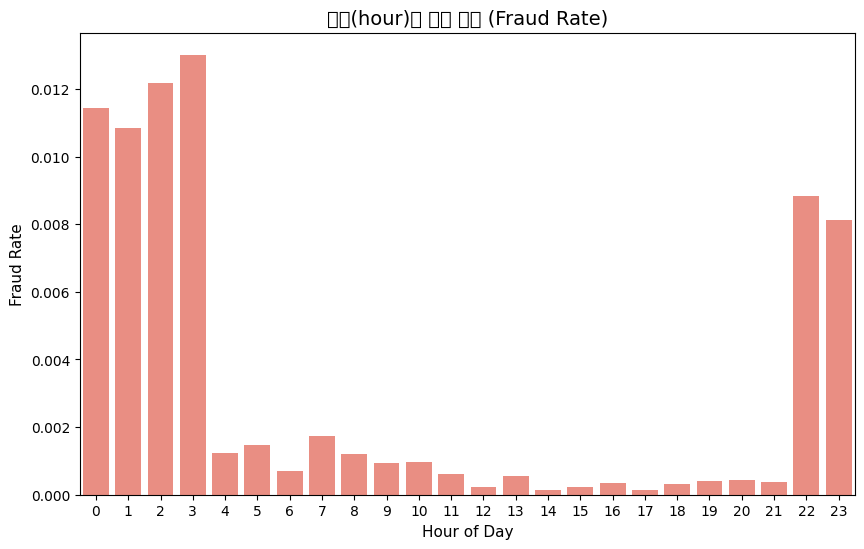

In [233]:
#시간대별 사기비율 계산 후 시각화로 직관적으로 보기

hour_fraud_rate = df.groupby('hour')['is_fraud'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=hour_fraud_rate, x='hour', y='is_fraud', color='salmon')

plt.title('시간(hour)별 사기 비율 (Fraud Rate)', fontsize=14)
plt.xlabel('Hour of Day', fontsize=11)
plt.ylabel('Fraud Rate', fontsize=11)
plt.xticks(range(24))

plt.show()


####사기거래 시간별 비율을 시각화한 결과, 0-3시와 22-23시에 사기 비율 급증 패턴 확인<br>
<strong>→ 즉, 심야~새벽 시간대가 사기 위험이 높은 구간임을 의미함</strong>


In [234]:
#요일별 패턴 확인
df['dayofweek'].value_counts().sort_index()
#평균패턴에서는 금토일에 거래가 상대적으로 높은 편임.

,count
dayofweek,
0,45884
1,50810
2,55631
3,56053
4,84404
5,103539
6,94813


In [235]:
df[df['is_fraud'] == 1]['dayofweek'].value_counts().sort_index()
#전체 요일에서 토요일, 일요일이 상대적으로 높음

,count
dayofweek,
0,121
1,146
2,145
3,121
4,188
5,266
6,257


<Figure size 1000x500 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


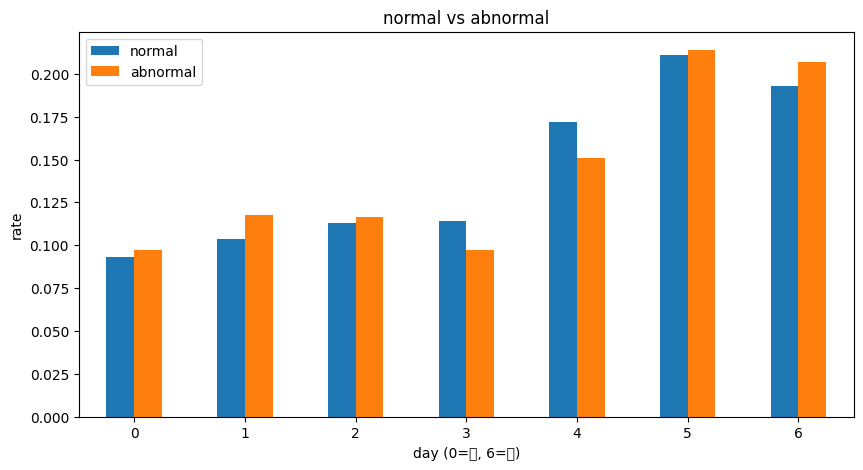

In [236]:
#시각화로 비교

# 정상/사기 각각 요일별 비율 계산
normal_rate = df[df['is_fraud']==0].groupby('dayofweek')['is_fraud'].count() / len(df[df['is_fraud']==0])
fraud_rate = df[df['is_fraud']==1].groupby('dayofweek')['is_fraud'].count() / len(df[df['is_fraud']==1])

plot_df = pd.DataFrame({
    'normal_rate': normal_rate,
    'fraud_rate': fraud_rate
}).reset_index()

plt.figure(figsize=(10,5))
plot_df.plot(x='dayofweek',
             kind='bar',
             figsize=(10,5))

plt.title("normal vs abnormal")
plt.xlabel("day (0=월, 6=일)")
plt.ylabel("rate")
plt.xticks(rotation=0)
plt.legend(["normal", "abnormal"])
plt.show()

<span style="color:red">

### 전반적인 거래량 패턴에서는 정상 및 사기 모두 흐름이 비슷함  
하지만 토요일과 일요일 사이에 **사기 비율이 약간 증가하는 경향 확인**  

➡️ **결론적으로 요일 자체는 강력한 기여 변수는 아닐 가능성이 높음**  
➡️ **다만, 주말에 사기 확률이 소폭 상승하는 패턴은 존재함**

</span>

---
##**금액 기반 EDA**
1. amt 전체 분포 파악  → 기본 분포 구조 이해
2. 정상 vs 사기 분포 비교  → 패턴 비교
3. 금액 구간별 사기 비율  → “금액이 올라갈수록 사기 증가?” 확인
4. 로그 변환(log_amt) 생성  → 모델 안정화용 FE

In [237]:
# 다시 한번 수치 확인
df['amt'].describe()

#표준편차가 엄청 큰 것으로 보아 매우 분산이 크다. 최소값과 최대값 차이 무지 큼.
#50% 이하까지는 소액결제, 50-70%사이는 중간정도 -> 대부분의 거래는 10-80$수준이나 max가 너무 뛰어서 확인 필요
#이런 경우 로그 변환이 필요한 대표적인 패턴임

,amt
count,491134.000000
mean,69.050120
std,160.322867
min,1.000000
25%,8.960000
50%,42.170000
75%,80.330000
max,25086.940000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50529 (\N{HANGUL SYLLABLE AEG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


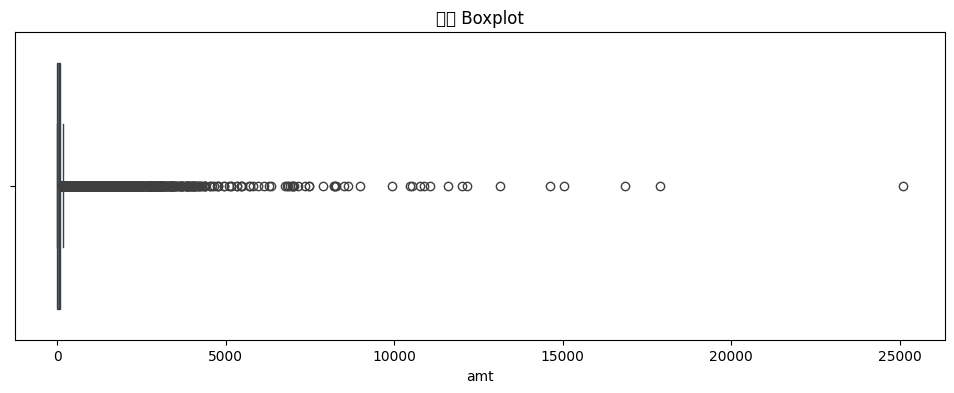

In [238]:
#시각화로 금액 분포 확인
plt.figure(figsize=(12,4))
sns.boxplot(x=df['amt'])
plt.title("금액 Boxplot")
plt.show()

# 오른쪽으로 극단적인 긴 꼬리 존재하며 이상치가 많아서 박스부분(IQR)이 보이지 않음 -> 로그변환 필요

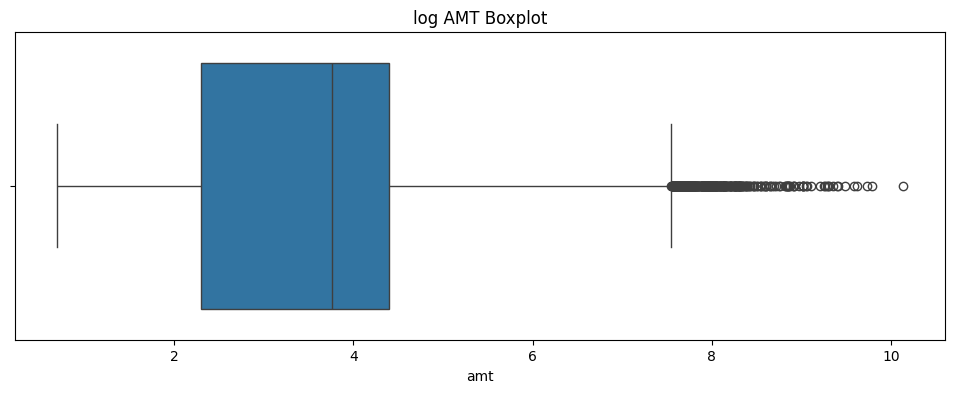

In [239]:
plt.figure(figsize=(12,4))
sns.boxplot(x=np.log1p(df['amt'])) #np.log1p(x) 이 넘파이 함수는 log(1+x)를 계산하는 것임. 금액이 0일수도 있으니까 log(1+0)으로 처리
plt.title("log AMT Boxplot")
plt.show()

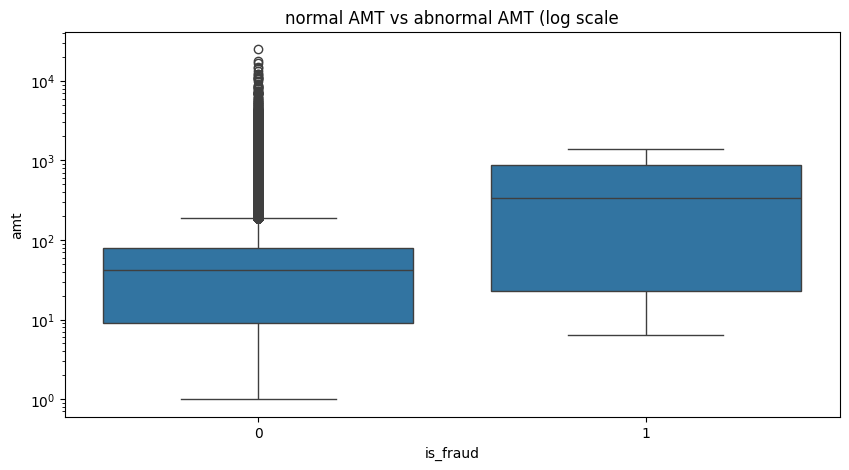

In [240]:
#정상과 사기금액을 박스플롯으로 로그스케일로 비교
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='is_fraud', y='amt')
plt.yscale('log')
plt.title("normal AMT vs abnormal AMT (log scale")
plt.show()

In [274]:
#로그로 변환된 amt 변수만들기
df['log_amt'] = np.log1p(df['amt'])

### 💳 금액(amt) 기반 정상 vs 사기 패턴 요약

- 사기 거래는 정상 거래보다 **기본 금액 자체가 크게 형성**됨  
- 정상 거래의 대부분은 **10~80달러 사이**에 몰려 있으나  
  사기 거래는 **100~1000달러 구간이 주요 범위**
- 전체적으로 **금액이 높을수록 사기 위험이 증가하는 패턴**이 명확함
- 원본 금액은 분포가 극도로 치우쳐 있어, **로그 변환 후 분석하는 것이 필수적**

In [275]:
#금액 구간별 사기 비율 보기 - 큰 금액일수록 사기일 확률이 높을까?
#1. 금액을 구간으로 나눈다
df['amt_bin'] = pd.qcut(df['amt'], q=10)
#pd.qcut() : 데이터를 동일 비율로 잘라 구간(bin)만들 때 사용, q=10 :10분위로 나눔


In [276]:
#2. 각 금액 구간별 사기 비율을 계산한다
fraud_rate_by_amt = df.groupby('amt_bin', observed=True)['is_fraud'].mean()

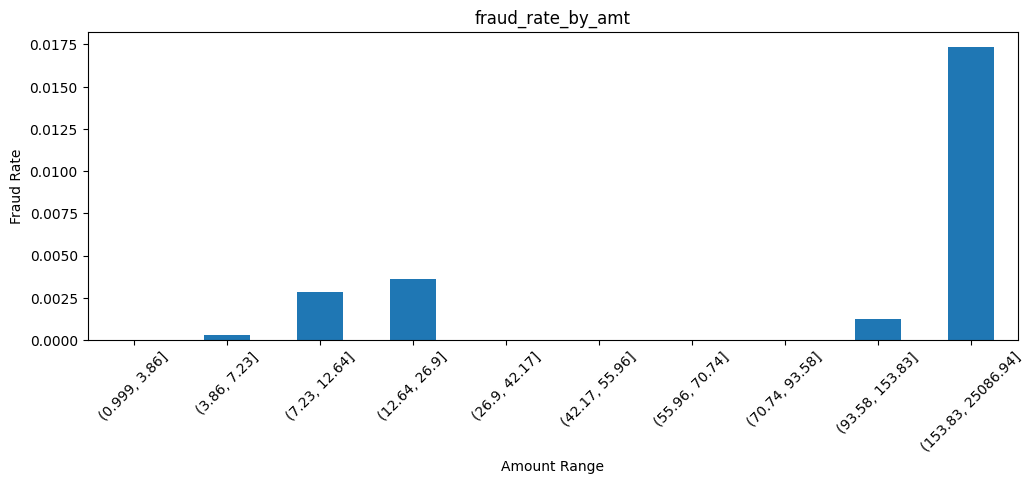

In [277]:
#3. 시각화로 확인
plt.figure(figsize=(12, 4))
fraud_rate_by_amt.plot(kind='bar')
plt.title("fraud_rate_by_amt")
plt.ylabel("Fraud Rate")
plt.xlabel("Amount Range")
plt.xticks(rotation=45)
plt.show()

#금액과 사기거래 간에 강력한 연관성이 있음을 보여줌. - 금액은 사기거래에서 중요한 변수임

### 💳 금액 기반 사기 패턴 요약

- 전체 금액 분포 중 극상위 구간에서 사기 비율이 폭증
- 특히, **153달러 이상 구간에서 Fraud Rate가 1.7%로 가장 높음**
- 93~153달러 구간도 사기 확률이 눈에 띄게 증가되는 양상
- 소액 구간에서는 거의 사기가 없지만,  
  일부 7~26달러 구간에서 상승 양상 관찰됨  
  **→ 이는 "소액 테스트 거래" 패턴 가능성 있음**
- 결론적으로 **금액(amt)은 사기 탐지에서 매우 중요한 Feature이며  
  고액 거래는 강력한 사기 위험 신호임**

####위의 결과를 바탕으로 금액 기반 파생변수 필요성 도출
1. log_amt : 모델 안정화용 (이미 만듦)
2. flag (특정 조건에 깃발표시!)
- high_amount_flag : 153달러 초과 구간이면 1
- medium_amount_flag :
- small_amount_flag : 30 이하



In [278]:
#구간별 파생변수 생성
df['low_amount_flag'] = (df['amt'] <= 30).astype(int)

In [279]:
df['medium_amount_flag'] = ((df['amt'] > 30) & (df['amt'] <= 153)).astype(int)

In [280]:
df['high_amount_flag'] = (df['amt'] > 153).astype(int)

In [281]:
df[['amt', 'low_amount_flag', 'medium_amount_flag', 'high_amount_flag']].head(20)

,amt,low_amount_flag,medium_amount_flag,high_amount_flag
0,107.23,0,1,0
1,44.71,0,1,0
2,46.28,0,1,0
3,64.09,0,1,0
4,25.58,1,0,0
5,207.36,0,0,1
6,181.35,0,0,1
7,53.60,0,1,0
8,102.13,0,1,0
9,83.07,0,1,0


---
##**위치 기반 EDA**

####파생변수 만들어가는 순서
1. 고객위치와 가맹점 거리(distance_km) 계산
2. 거리 변수로 인해 연관성이 생기는 속성들을 flag로 파생 변수만들기 (예. 먼거리?)

In [282]:
#거리 변수 생성 (위도와 경도를 이용한 두 점 사이 실제 지구 곡면 거리 계산하는 Haversine 공식이라는 게 있다고 함.)
#Haversine 거리 계산 함수
def haversine_distance(lat1, lon1, lat2, lon2):
    # 1) radians 로 변환 (삼각함수는 radians 기준으로 동작)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # 2) 두 점 간 위도/경도 차이 계산
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # 3) Haversine (지구 곡면 기준 거리 계산 함수) 적용
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    # 4) 지구 반지름(6371km) × 각도 차이 = 실제 거리(km)
    R = 6371
    return R * c

# 실제 거리 계산하여 새 컬럼 생성
df['distance_km'] = haversine_distance(df['cust_lat'], df['cust_long'],df['store_lat'], df['store_long'])


In [283]:
df['distance_km'].describe()

#최소값을 보면 집근처 거래도 있음
#하위 25%는 55km 이내 발생
#하위 50%는 주소지와 78.5km 정도 범위에서 발생
#최대값을 보면 최대 149.8km 정도로 보임

,distance_km
count,491134.000000
mean,76.378645
std,29.169541
min,0.123883
25%,55.578144
50%,78.540025
75%,98.766507
max,149.804444


In [284]:
#거리구간별 사기 비율 보기
df['dist_bin'] = pd.qcut(df['distance_km'], q=10)

In [285]:
fraud_rate_by_dist = df.groupby('dist_bin')['is_fraud'].mean()
fraud_rate_by_dist

/tmp/ipython-input-1973673848.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_dist = df.groupby('dist_bin')['is_fraud'].mean()


,is_fraud
dist_bin,
"(0.123, 35.116]",0.002464
"(35.116, 49.682]",0.002342
"(49.682, 60.871]",0.002504
"(60.871, 70.249]",0.002423
"(70.249, 78.54]",0.002810
"(78.54, 86.321]",0.002647
"(86.321, 94.405]",0.002443
"(94.405, 103.32]",0.002749
"(103.32, 113.119]",0.002566


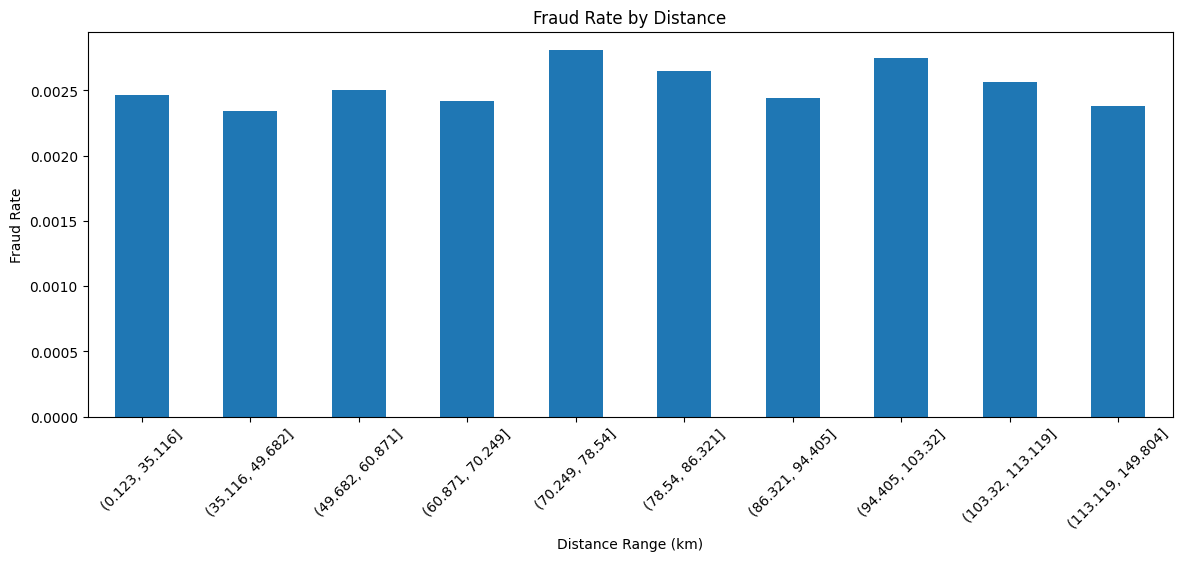

In [286]:
#거리 구간별 사기비율 시각화
plt.figure(figsize=(14,5))
fraud_rate_by_dist.plot(kind='bar')
plt.title("Fraud Rate by Distance")
plt.ylabel("Fraud Rate")
plt.xlabel("Distance Range (km)")
plt.xticks(rotation=45)
plt.show()

####거리 기반 EDA 결과, 고객주소와 가맹점 거리와 사기 비율 사이에는 뚜렷한 상관관계가 확인 안 됨전체 거리 구간의 사기율은 0.0023~0.0028 사이에 머무르며 특정 구간에서 튀는 패턴 없음.

####**→ 따라서 distance_km 변수는 유지하지만, 거리 기준 이진 변수(is_far_flag)는 생성하지 않기로 함.**

In [287]:
df['is_fraud'].value_counts()

,count
is_fraud,
0,489890
1,1244


In [288]:
#사기거래에서 실제 주소지랑 가맹점 사이 거리간에 특정 패턴이 안 보이는지 시각화 점검 시도

# 1. 사기 거래만 필터링
fraud_df = df[df["is_fraud"] == 1]

# 지도 중심
center_lat = fraud_df["store_lat"].mean()
center_long = fraud_df["store_long"].mean()
m = folium.Map(location=[center_lat, center_long], zoom_start=5)

# 2. 전체 사기 거래는 클러스터로 표시
cluster = MarkerCluster().add_to(m)

for _, row in fraud_df.iterrows():
    folium.CircleMarker(
        location=[row['store_lat'], row['store_long']],
        radius=4,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(cluster)

# 3. 특정 거리 이상인 경우만 고객 ↔ 가맹점 연결
DIST_THRESHOLD = 120  # <-- 원하는 거리 기준 설정

far_fraud = fraud_df[fraud_df["distance_km"] > DIST_THRESHOLD]

for _, row in far_fraud.iterrows():
    # 고객 위치 (파란 점)
    folium.CircleMarker(
        location=[row['cust_lat'], row['cust_long']],
        radius=4,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup="Customer Home"
    ).add_to(m)

    # 가맹점 위치 (빨간 점)
    folium.CircleMarker(
        location=[row['store_lat'], row['store_long']],
        radius=6,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        popup=f"Fraud Amount: {row['amt']}"
    ).add_to(m)

    # 고객 → 가맹점 선 연결
    folium.PolyLine(
        locations=[
            [row['cust_lat'], row['cust_long']],
            [row['store_lat'], row['store_long']]
        ],
        color="orange",
        weight=2,
        opacity=0.6
    ).add_to(m)

m

#### 단순 거리 구간 변수로는 사기 패턴을 잘 설명하지 못함.
#### 맵으로도 비정상 거래에서의 고객위치와 가맹점 위치 확인 시 뚜렷한 이상 패턴을 감지하기 어려웠음.
####**-> 거리는 단일 변수로는 사기거래를 예측하기엔 약한 특징으로 판단됨. 하지만, 시간이나 금액 등의 요소와 결합되면 시너지 나는 속성이 될 가능성은 여전히 있으므로 제거하지 않고 유지**
---
### 다음 가설 확인 가능할까? 먼거리에서 심야시간에 결제하면 사기일 확률이 높다.




In [289]:
# 먼거리 파생변수 만들기
df['night_far_flag'] = ((df['is_night'] == 1) & (df['distance_km'] > 100)).astype(int)

In [290]:
#위에서의 사기 비율 비교
df.groupby('night_far_flag')['is_fraud'].mean()

,is_fraud
night_far_flag,
0,0.002334
1,0.008255


In [291]:
df[df['is_fraud'] == 1]['is_night'].value_counts(normalize=True)

,proportion
is_night,
0,0.533762
1,0.466238


####거리 단독으로는 의미가 없었지만, 거리와 심야시간을 조합하니 심야시간이라는 단독변수와 비교했을 때보다도 사기 확률이 증가하였음. (일반거래 0.23 대비 0.83으로 약 3.5배 높은 수치)
####**"심야(0-5시)+먼거리(100km 초과)" 조합은 강력한 사기 탐지 신호임. 혼합 파생변수가 모델 성능 향상에 기여할 수 있을 것을 시사함.**

---
##**업종 기반 EDA**

In [292]:
df.head()

,cc_num,merchant,category,amt,gender,cust_lat,cust_long,city_pop,unix_time,store_lat,store_long,is_fraud,transaction_time,hour,dayofweek,month,is_weekend,is_night,amt_bin,low_amount_flag,medium_amount_flag,high_amount_flag,distance_km,dist_bin,night_far_flag,online_flag,high_risk_cat_flag,category_fraud_score,log_amt
0,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,2012-01-01 00:00:44,0,6,1,1,1,"(93.58, 153.83]",0,1,0,30.212176,"(0.123, 35.116]",0,0,1,0.005056,4.684259
1,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,M,40.6747,-74.2239,124967,1325376754,40.079588,-74.848087,0,2012-01-01 00:12:34,0,6,1,1,1,"(42.17, 55.96]",0,1,0,84.702120,"(78.54, 86.321]",0,0,1,0.005056,3.822317
2,180048185037117,fraud_Kling-Grant,grocery_net,46.28,F,40.6152,-74.4150,71485,1325377036,40.021888,-74.228188,0,2012-01-01 00:17:16,0,6,1,1,1,"(42.17, 55.96]",0,1,0,67.847742,"(60.871, 70.249]",0,1,0,0.000327,3.856087
3,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,M,42.2203,-83.3583,31515,1325377215,42.360426,-83.552316,0,2012-01-01 00:20:15,0,6,1,1,1,"(55.96, 70.74]",0,1,0,22.303906,"(0.123, 35.116]",0,0,1,0.005056,4.175771
4,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,F,30.4066,-91.1468,378909,1325377421,29.737426,-90.853194,0,2012-01-01 00:23:41,0,6,1,1,1,"(12.64, 26.9]",1,0,0,79.591943,"(78.54, 86.321]",0,0,0,0.001759,3.280159


In [293]:
df['category'] = df['category'].astype(str)

In [294]:
df['category'].value_counts()

,count
category,
shopping_pos,48345
gas_transport,46029
home,43340
grocery_pos,42722
kids_pets,40295
shopping_net,39179
food_dining,35980
personal_care,35513
entertainment,33619


In [295]:
fraud_rate_by_cat = df.groupby('category')['is_fraud'].mean().sort_values(ascending=False)
fraud_rate_by_cat

,is_fraud
category,
shopping_net,0.006177
grocery_pos,0.005056
misc_net,0.004329
shopping_pos,0.002772
gas_transport,0.002194
travel,0.001902
misc_pos,0.001759
food_dining,0.001723
kids_pets,0.001688


/tmp/ipython-input-539171195.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(order, rotation=45, ha='right')


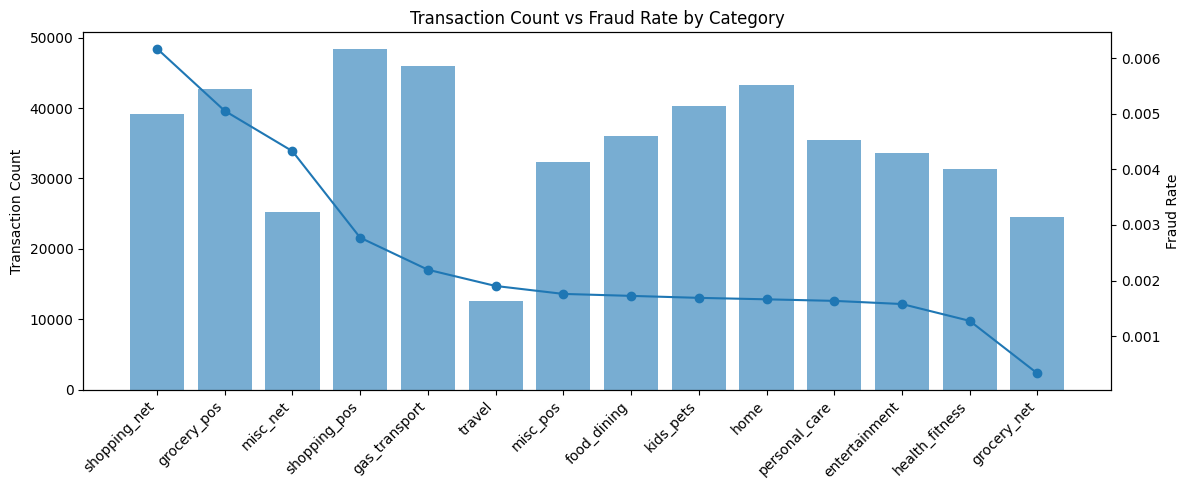

In [296]:
#시각화

# 1) 업종별 거래수 & 사기율 데이터 준비
cat_counts = df['category'].value_counts()
fraud_rate_by_cat = df.groupby('category')['is_fraud'].mean()

# 인덱스를 동일한 순서로 맞추기 (사기율 높은 순으로 정렬 기준)
order = fraud_rate_by_cat.sort_values(ascending=False).index

cat_counts = cat_counts[order]
fraud_rate_sorted = fraud_rate_by_cat[order]

# 2) 그래프 그리기
plt.figure(figsize=(12,5))

ax1 = plt.gca()  # 첫 번째 y축 (왼쪽): 거래 건수
ax2 = ax1.twinx()  # 두 번째 y축 (오른쪽): 사기 비율

# 바 차트: 거래 건수
ax1.bar(order, cat_counts, alpha=0.6)
ax1.set_ylabel('Transaction Count')
ax1.set_xticklabels(order, rotation=45, ha='right')

# 선 그래프: 사기 비율
ax2.plot(order, fraud_rate_sorted, marker='o')
ax2.set_ylabel('Fraud Rate')

plt.title('Transaction Count vs Fraud Rate by Category')
plt.tight_layout()
plt.show()

####그래프 요약
	- 온라인 쇼핑(shopping_net) 은 거래량 대비 사기비율이 높은 업종
	- grocery_pos(식료품 오프라인) 은 거래량도 많고 사기 비율도 높음 → 위험도가 특히 큰 업종
	- misc_net(기타 온라인)도 거래량 대비 사기 비율이 높음
    - 그 외 오프라인 업종들은 대부분 사기 거래가 낮고 안정정인 패턴

####**-> 온/오프라인 분류로 파생변수를 만드는 건 의미가 없어보이며 업종별 사기 위험점수를 반영하면 모델링에 효과적일 것으로 예상함.**

In [297]:
#일단 온라인 flag 만듦 - 문자열에 _net 유무로 True=1, False=0으로 변환
df['online_flag'] = df['category'].str.contains('_net').astype(int)

In [298]:
#고위험 업종 flag 만듦 - 그래프로 확인한 고위험 3업종에 하나라도 해당하면 True =1 로 변환
high_risk = ['shopping_net', 'grocery_pos', 'misc_net']
df['high_risk_cat_flag'] = df['category'].isin(high_risk).astype(int)

In [299]:
#업종별 사기 위험 점수 파생변수 만들기 (category_fraud_score) - 업종별 사기 비율을 각 카테고리별 대응값으로 치환
fraud_rate_map = fraud_rate_by_cat.to_dict()
df['category_fraud_score'] = df['category'].map(fraud_rate_map)

In [300]:
df.head()

,cc_num,merchant,category,amt,gender,cust_lat,cust_long,city_pop,unix_time,store_lat,store_long,is_fraud,transaction_time,hour,dayofweek,month,is_weekend,is_night,amt_bin,low_amount_flag,medium_amount_flag,high_amount_flag,distance_km,dist_bin,night_far_flag,online_flag,high_risk_cat_flag,category_fraud_score,log_amt
0,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,48.8878,-118.2105,149,1325376044,49.159047,-118.186462,0,2012-01-01 00:00:44,0,6,1,1,1,"(93.58, 153.83]",0,1,0,30.212176,"(0.123, 35.116]",0,0,1,0.005056,4.684259
1,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,M,40.6747,-74.2239,124967,1325376754,40.079588,-74.848087,0,2012-01-01 00:12:34,0,6,1,1,1,"(42.17, 55.96]",0,1,0,84.702120,"(78.54, 86.321]",0,0,1,0.005056,3.822317
2,180048185037117,fraud_Kling-Grant,grocery_net,46.28,F,40.6152,-74.4150,71485,1325377036,40.021888,-74.228188,0,2012-01-01 00:17:16,0,6,1,1,1,"(42.17, 55.96]",0,1,0,67.847742,"(60.871, 70.249]",0,1,0,0.000327,3.856087
3,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,M,42.2203,-83.3583,31515,1325377215,42.360426,-83.552316,0,2012-01-01 00:20:15,0,6,1,1,1,"(55.96, 70.74]",0,1,0,22.303906,"(0.123, 35.116]",0,0,1,0.005056,4.175771
4,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,F,30.4066,-91.1468,378909,1325377421,29.737426,-90.853194,0,2012-01-01 00:23:41,0,6,1,1,1,"(12.64, 26.9]",1,0,0,79.591943,"(78.54, 86.321]",0,0,0,0.001759,3.280159


##**모델링 전 Feature 영향력 검토**

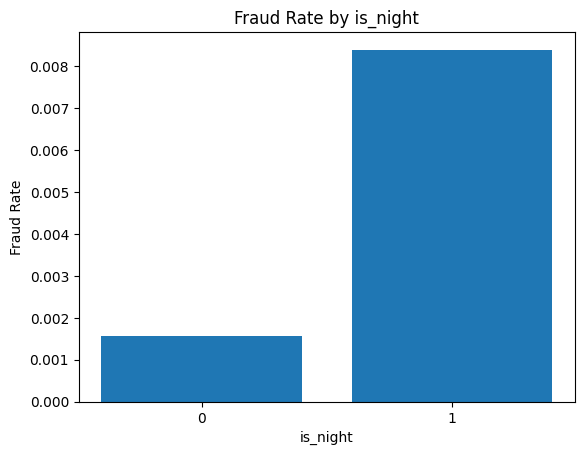

In [301]:
#심야시간
rate = df.groupby('is_night')['is_fraud'].mean()

plt.bar(rate.index.astype(str), rate.values)
plt.title("Fraud Rate by is_night")
plt.xlabel("is_night")
plt.ylabel("Fraud Rate")
plt.show()

<Figure size 800x500 with 0 Axes>

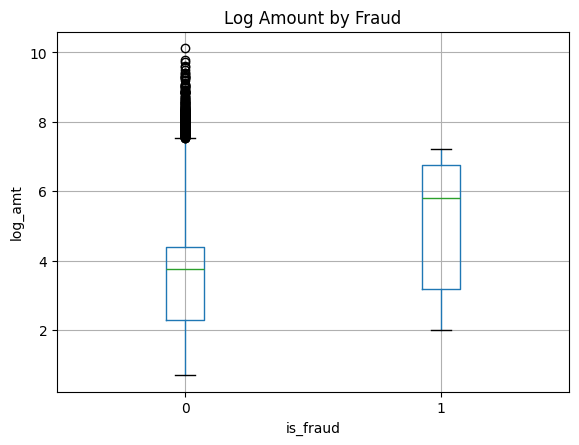

In [302]:
plt.figure(figsize=(8,5))
df.boxplot(column='log_amt', by='is_fraud')
plt.title("Log Amount by Fraud")
plt.suptitle("")
plt.ylabel("log_amt")
plt.show()

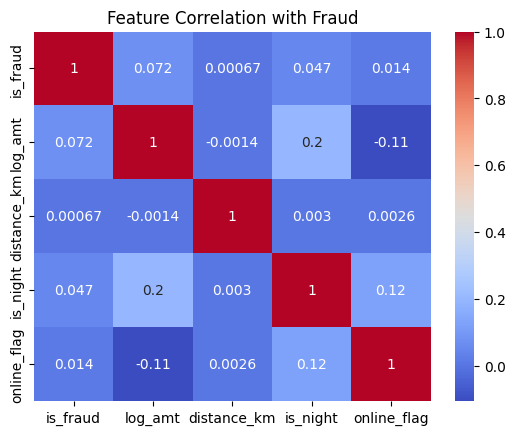

In [303]:
#상관관계 히트맵

corr = df[['is_fraud','log_amt','distance_km','is_night','online_flag']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Fraud")
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50728 (\N{HANGUL SYLLABLE ON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


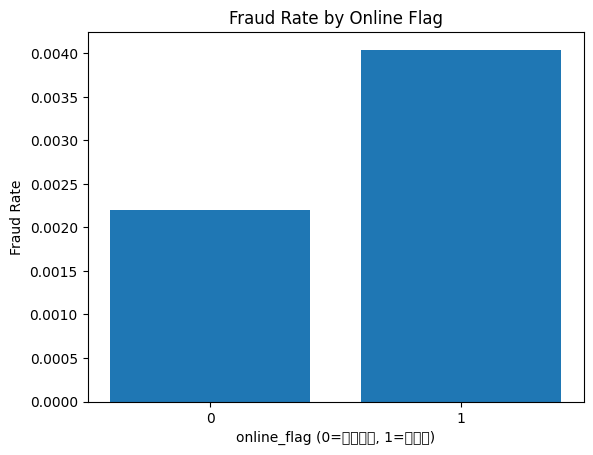

In [304]:
#온라인 여부 영향
fraud_rate_online = df.groupby('online_flag')['is_fraud'].mean()

plt.bar(fraud_rate_online.index.astype(str), fraud_rate_online.values)
plt.title("Fraud Rate by Online Flag")
plt.xlabel("online_flag (0=오프라인, 1=온라인)")
plt.ylabel("Fraud Rate")
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49900 (\N{HANGUL SYLLABLE SIM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50556 (\N{HANGUL SYLLABLE YA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47676 (\N{HANGUL SYLLABLE MEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

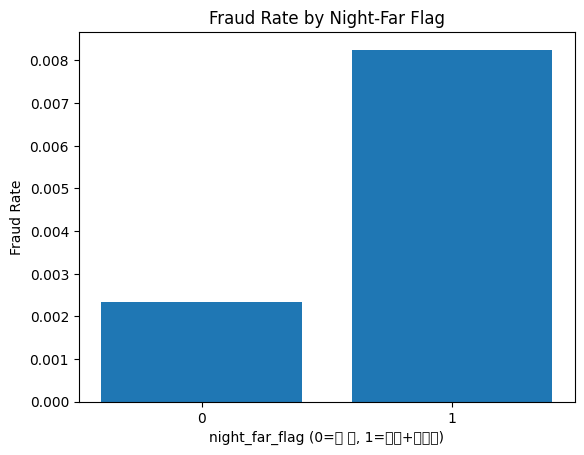

In [305]:
#심야+먼거리 조합 영향
fraud_rate_nf = df.groupby('night_far_flag')['is_fraud'].mean()

plt.bar(fraud_rate_nf.index.astype(str), fraud_rate_nf.values)
plt.title("Fraud Rate by Night-Far Flag")
plt.xlabel("night_far_flag (0=그 외, 1=심야+먼거리)")
plt.ylabel("Fraud Rate")
plt.show()


---


#5단계. 모델링(Modeling) 단계
1. Train/Test
2. baseline 모델 정의 (Logistic Regression, Random Forest)
3. 불균형 처리
4. 평가지표 선정


In [306]:
from sklearn.model_selection import train_test_split

# 모델에 사용할 feature 선택
features = [
    'log_amt', 'distance_km', 'is_night', 'is_weekend',
    'low_amount_flag', 'medium_amount_flag', 'high_amount_flag',
    'online_flag', 'night_far_flag'
]

X = df[features]
y = df['is_fraud']

# train-test split
# stratify는 비율을 그대로 유지하면서 섞어서 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

len(X_train), len(X_test), y_train.mean(), y_test.mean()

(392907,
 98227,
 np.float64(0.00253240588739829),
 np.float64(0.002534944567176031))

####**데이터 불균형이 있으므로 Train 데이터에서 불균형 보정 필요**

- SMOTE(오버샘플링)은 소수 클래스를 실제 복제/보간해서 개수를 늘려줌 (데이터 양이 증가하므로 학습은 오래걸릴 수 있다)
- class_weight = 'balanced' 는 데이터는 그대로 두되, 모델이 사기클래스 실수를 더 크게 패널티 주도록 학습시킨다. 이건 데이터 양 변화없음.

In [307]:
#불균형 처리

from imblearn.over_sampling import SMOTE

# 1) SMOTE 객체 생성
smote = SMOTE(random_state=42)

# 2) train 데이터에만 적용 (X_test, y_test는 건들지 않음)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 3) 비율 확인
print("원래 y_train 분포:")
print(y_train.value_counts(normalize=True))

print("\nSMOTE 이후 y_train_sm 분포:")
print(y_train_sm.value_counts(normalize=True))

원래 y_train 분포:
is_fraud
0    0.997468
1    0.002532
Name: proportion, dtype: float64

SMOTE 이후 y_train_sm 분포:
is_fraud
0    0.5
1    0.5
Name: proportion, dtype: float64


In [308]:
#SMOTE 데이터로 RandomForest 학습하기
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

rf_sm = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,         # 여기선 class_weight 안 써도 됨 (이미 oversampling 했으니까)
)

rf_sm.fit(X_train_sm, y_train_sm)

# test는 원본 그대로!
rf_pred = rf_sm.predict(X_test)
rf_prob = rf_sm.predict_proba(X_test)[:, 1]

print("===== Random Forest (with SMOTE) =====")
print(classification_report(y_test, rf_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, rf_prob))
print("PR-AUC (AUPRC):", average_precision_score(y_test, rf_prob))

===== Random Forest (with SMOTE) =====
              precision    recall  f1-score   support

           0     0.9994    0.9115    0.9534     97978
           1     0.0222    0.7912    0.0432       249

    accuracy                         0.9112     98227
   macro avg     0.5108    0.8513    0.4983     98227
weighted avg     0.9969    0.9112    0.9511     98227

ROC-AUC: 0.9383364768141951
PR-AUC (AUPRC): 0.30993968366624136


In [309]:
#baseline 모델 학습
rf_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    class_weight='balanced'   # SMOTE 없이 불균형 보정용
)

rf_base.fit(X_train, y_train)

rf_base_pred = rf_base.predict(X_test)
rf_base_prob = rf_base.predict_proba(X_test)[:, 1]

print("===== Baseline Random Forest (NO SMOTE) =====")
print(classification_report(y_test, rf_base_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, rf_base_prob))
print("PR-AUC:", average_precision_score(y_test, rf_base_prob))

===== Baseline Random Forest (NO SMOTE) =====
              precision    recall  f1-score   support

           0     0.9993    0.9611    0.9798     97978
           1     0.0460    0.7390    0.0866       249

    accuracy                         0.9605     98227
   macro avg     0.5227    0.8500    0.5332     98227
weighted avg     0.9969    0.9605    0.9776     98227

ROC-AUC: 0.952686473096452
PR-AUC: 0.2810741676662521


##**SMOTE 적용한 Random Forest 결과요약**
정상(0) precision = 0.9994  
정상(0) recall = 0.9115  

사기(1) precision = 0.0222  
사기(1) recall = 0.7912

[참고]
- **ROC-AUC (전체적인 판별 능력을 보는 지표)** : 0-1값으로 1이 완벽한 분류했다. 0.9 이상이면 좋은 모델  
ROC curve는 다양한 Threshold(0-1) 바꿨을 때 재현율과 거짓경보율의 관계를 그린 것이므로 역치값 조정 상관없이 전반적으로 구분능력이 좋은지를 보여줌.
- **PR-AUC(Precision-Recall curve)** : 데이터가 불균형인 상황에서 진짜 중요성능지표로 쓰임.   
베이스라인과 조정한 모델 사이에 성능 비교를 위해 참고할 수 있는 값임.

##**핵심 해석**
1. 사기 거래 탐지 성능(Recall) 값이 79%에 달하여 불균형을 해소하고 예측률을 높인 것을 알 수 있음.
2. 사기 거래의 Precision 이 2.2%이므로 결국 사기로 예측한 거래의 97.8%가 실제로는 정상 거래임. 즉 사기를 잘 잡는대신 정상까지 많이 포함시키는 모델 구조임 --> 추가 필터링 또는 Threshold 조정 필요
3. 전체적인 분류 성능(ROC-AUC)는 0.938이 나와 전체적인 판별 능력은 양호함
4. PR-AUC는 데이터 사기 비율이 전체에서 0.24%(0.0025)였는데 현재 0.31 수준이므로 100배 이상으로 향상되어 **극도로 불균형인 데이터에서 의미있는 개선을 달성**했다고 보여짐.

##**베이스라인(class_weight 적용한 Random Forest)와 비교**
- SMOTE 적용한 것이 사기 탐지 성능은 좀 더 좋음 (73.9% vs. 79.1%)
- 사기 Precision은 SMOTE가 상당히 떨어짐 (4.6% vs. 2.22%)
- ROC-AUC는 베이스라인이 더 좋음 (0.95 vs.0.93)
- PR-AUC는 SMOTE가 더 좋음 (0.28 vs. 0.31)

##**결론**##
Baseline RandomForest는 전체적인 분류 정확도 및 안정성이 우수하지만,
사기 탐지 Recall 측면에서는 SMOTE 기반 모델이 더 높은 탐지율을 제공한다.
특히, 극도로 불균형한 데이터에서 핵심 지표인 PR-AUC가 SMOTE 모델에서 더 높게 나타나
사기 탐지 성능 자체는 SMOTE 모델이 더 우수하다고 판단된다.
다만, Precision은 Baseline보다 낮아 False Positive 증가가 예상되므로
실 적용 시 threshold 조정이 필요하다.


---
##**Threshold 튜닝**
RandomForest 같은 확률기반 모델은 기본적으로 0.5 이상이면 사기라고 분류하지만 사기데이터가 극도로 적기 때문에 그 결과 Precision이 매우 낮고, 또한 Recall도 완벽하지 않을 수 있음. 따라서 사기를 잘 잡으면서 정상오탐이 너무 많지 않는 적당한 지점을 찾아야 함.


In [310]:
#threshold별 성능 평가 함수 만들기
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_threshold(model, X_test, y_test, thresholds=np.arange(0.05, 0.51, 0.05)):
    probs = model.predict_proba(X_test)[:, 1]
    results = []

    for t in thresholds:
        preds = (probs >= t).astype(int)
        precision = precision_score(y_test, preds, zero_division=0)
        recall = recall_score(y_test, preds, zero_division=0)
        f1 = f1_score(y_test, preds, zero_division=0)
        results.append([t, precision, recall, f1])

    eval_df = pd.DataFrame(results, columns=['threshold', 'precision', 'recall', 'f1'])
    return eval_df

In [311]:
threshold_results = evaluate_threshold(rf_sm, X_test, y_test)
threshold_results

,threshold,precision,recall,f1
0,0.05,0.010652,0.931727,0.021064
1,0.10,0.012062,0.907631,0.023807
2,0.15,0.012891,0.899598,0.025417
3,0.20,0.013808,0.895582,0.027197
4,0.25,0.014302,0.871486,0.028142
5,0.30,0.015434,0.855422,0.030320
6,0.35,0.016915,0.839357,0.033161
7,0.40,0.018866,0.823293,0.036887
8,0.45,0.020947,0.803213,0.040829
9,0.50,0.022205,0.791165,0.043197


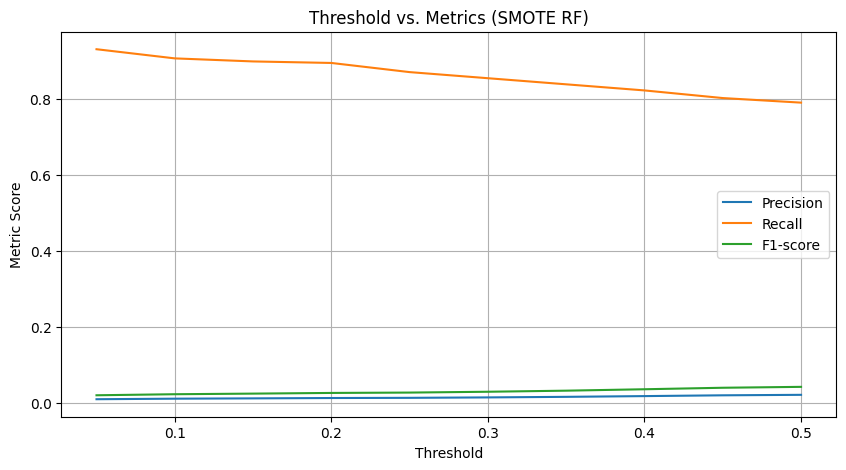

In [312]:
#시각화로 threshold 차이에 따른 성능 확인
plt.figure(figsize=(10,5))
plt.plot(threshold_results['threshold'], threshold_results['precision'], label='Precision')
plt.plot(threshold_results['threshold'], threshold_results['recall'], label='Recall')
plt.plot(threshold_results['threshold'], threshold_results['f1'], label='F1-score')
plt.xlabel('Threshold')
plt.ylabel('Metric Score')
plt.title('Threshold vs. Metrics (SMOTE RF)')
plt.legend()
plt.grid(True)
plt.show()

##**조정방향 목표 - Recall 유지 + Precision 조금 향상 (둘의 균형)**
-> 0.35-0.4 사이에서 정하기로 함.

[실무적인 생각]
사기 놓치면 금전 손해가 많고 신뢰도가 떨어지므로 Recall을 가급적 최우선으로 신경쓰기. 하지만 많은 오탐이 고객 불만이나 신뢰도에 영향을 미치므로 이 또한 함께 살펴야 함.

In [317]:
from sklearn.metrics import classification_report, confusion_matrix

# 1) SMOTE 모델(rf_sm)로 테스트셋 확률 예측
pred_proba = rf_sm.predict_proba(X_test)[:, 1]

# 2) threshold=0.4 기준으로 이진 예측 생성
threshold = 0.4
y_pred_th = (pred_proba >= threshold).astype(int)

# 3) 성능 지표 출력
print(f"===== Random Forest (with SMOTE, threshold={threshold}) =====")
print(classification_report(y_test, y_pred_th, digits=4))

# 4) 혼동행렬도 같이 확인
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_th))

===== Random Forest (with SMOTE, threshold=0.4) =====
              precision    recall  f1-score   support

           0     0.9995    0.8912    0.9422     97978
           1     0.0189    0.8233    0.0369       249

    accuracy                         0.8910     98227
   macro avg     0.5092    0.8572    0.4896     98227
weighted avg     0.9970    0.8910    0.9399     98227

Confusion Matrix:
[[87317 10661]
 [   44   205]]


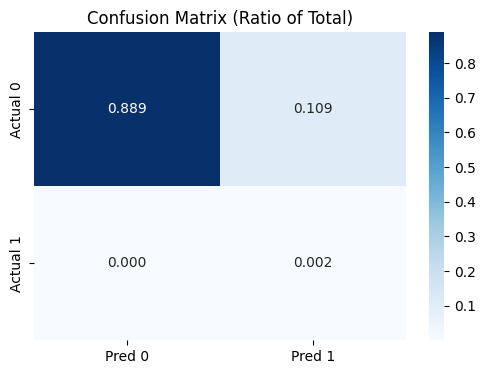

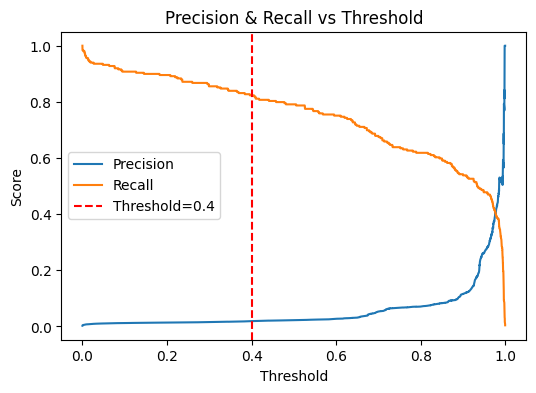

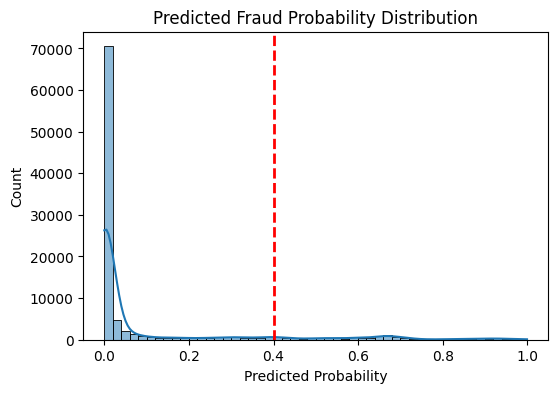

In [320]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve

# 1) 확률 예측
pred_proba = rf_sm.predict_proba(X_test)[:, 1]
threshold = 0.4
y_pred_th = (pred_proba >= threshold).astype(int)


#Confusion Matrix - 사기 적발과 정상 오판은 어느정도인가?
cm = confusion_matrix(y_test, y_pred_th)

# 전체 대비 비율
cm_ratio = cm / cm.sum()

plt.figure(figsize=(6,4))
sns.heatmap(cm_ratio, annot=True, fmt=".3f", cmap="Blues",
            xticklabels=['Pred 0','Pred 1'],
            yticklabels=['Actual 0','Actual 1'])
plt.title("Confusion Matrix (Ratio of Total)")
plt.show()


#Precision–Recall Curve + threshold 위치 표시  - 절충점 확인
prec, rec, thres = precision_recall_curve(y_test, pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(thres, prec[:-1], label="Precision")
plt.plot(thres, rec[:-1], label="Recall")
plt.axvline(x=threshold, color="red", linestyle="--", label=f"Threshold={threshold}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.show()


# 예측 확률 분포 + threshold 라인
plt.figure(figsize=(6, 4))
sns.histplot(pred_proba, bins=50, kde=True)
plt.axvline(x=threshold, color="red", linestyle="--", linewidth=2)
plt.title("Predicted Fraud Probability Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.show()

 ##**최종 모델 결과 해석 (Random Forest + SMOTE + Threshold=0.4)** <br>

 본래 목표 사기를 최대한 놓치지 않고 잡아내는 사기거래 탐지 모델에 대한 것으로 설정하였으므로 **평가는 Recall값(82%)과 PR-AUC (0.31로 베이스라인 대비 100배이상 개선)중심으로 해석할 수 있음.**
- 원래 default threshold 는 0.5인데 0.4로 조정하여 재현율(recall 82%)은 충분히 유지 하면서 정밀도(precision 2% -> 2.1%) 부분도 조금 더 개선시킴.
- **confusion matrix 해석:** 정상거래(Actual=0)예측은 88.9%(TN)잘 분류됨. 10.9%는 사기로 잘못 분류됨 (FP) : FP가 증가했지만 이는 사기누락을 최소화하기 위해감수해야하는 부분임. 실제 사기거래(Actual1)에서 거의 0프로 누각이므로 FN(사기 누락)을 최소화함.<br>
-**성능지표 해석** : ROC-AUC 값이 0.94이므로 전반적인 판단 능력은 우수하다 보여지며,PR-AUC값 0.31을 통해 사기 비중 0.25%라는 극도의 불균형 환경에서 상당한 개선을 시행하였음.




##**📝 프로젝트 회고 (Retrospective)**

#####본 프로젝트는 그동안 배웠던 데이터 처리와 모델링, 그리고 최적의 예측모델을 찾기 위한 feature engineering 파트를 종합적으로 연습하고 복습하는 시간이었다.<br> 특히 **이번 데이터는 타깃변수가 극도로 불균형한(binary imbalance) 문제**를 가지고 있었는데 **이 경우 정확도는 의미가 없고 다른 평가지표를 사용해야 한다는 것을 실제 분석과 해석 과정을 거치면서 몸으로 이해할 수 있었다.** 또한 불균형 조정을 위해 사용한 SMOTE 같은 오버샘플링 기법의 역할과 효과도 체감할 수 있었다.<br>  그리고 EDA 과정에서 시간대·금액·업종·거리 기반 변수들을 직접 만들면서, **단순한 raw 데이터에서는 보이지 않던 패턴을 파생변수로 드러낼 수 있다는 사실**을 다시 한 번 확인했다. 이런 Feature Engineering이 후반부 모델 성능 개선에 유효하게 작용했다는 점도 의미 있었다. <br>  모델링에서는 랜덤포레스트 기반으로 baseline과 SMOTE 버전을 비교하며,**“성능값으로 선정한 모델과 실제로 사업적으로 목표로 하는 방향에 걸맞는 예측 모델**에는 차이가 있을 수 있겠다는 생각을 했다. <br> 전체적으로 이번 프로젝트는 머신러닝 파이프라인 전 과정을 배우고,특히 불균형 데이터 처리와 실무적 판단 기준을 깊게 이해하는 데 큰 도움이 되었다.